# Install PyTorch

(Optional) Check the version of your system.

In [0]:
! uname -a
! python --version
! nvcc --version

Install PyTorch by pip.

In [0]:
! pip3 install torch torchvision

# Set up your data

Mount your google drive, where you keep your data (cs-ioc5008-hw1.zip).

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


Unzip it to your home directory.

In [0]:
! unzip -q /gdrive/'My Drive'/'Colab Notebooks'/cs-ioc5008-hw1.zip -d ./

(Deprecated) If you don't want to use google drive, just upload cs-ioc5008-hw1.zip and unzip it.

In [0]:
#from google.colab import files
#files.upload()
#! unzip cs-ioc5008-hw1.zip

# Main function start

Import all the packages we need.

In [0]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd

Load the data. Seperate it into training and validation set.

In [0]:
# Define the transform apply on the dataset.
data_transform = transforms.Compose([
    # transforms.RandomSizedCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225])
])
# Load the dataset.
hw1_dataset = datasets.ImageFolder(root='dataset/dataset/train',
                                   transform=data_transform)
data_classes = hw1_dataset.classes

# Split the dataset into training and testing set.
torch.manual_seed(1)
split_point = int(len(hw1_dataset) * 0.7)
indices = torch.randperm(len(hw1_dataset)).tolist()
dataset = torch.utils.data.Subset(hw1_dataset, indices[:split_point])
dataset_test = torch.utils.data.Subset(hw1_dataset, indices[split_point:])

# Define training and validation data loaders.
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4)

Show the picture. We can know that whether we have loaded the data correctly or not.

torch.Size([1, 3, 256, 256]) torch.Size([1])


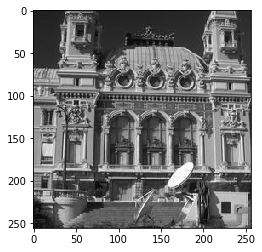

In [15]:
for batched_data, label in data_loader_test:
    print(batched_data.size(), label.size())
    
    # Show image.
    npimg = batched_data[0].numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    break

Build a CNN model.

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Get the pretrained model.
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
# Modify the ouput layer to fit our task.
num_features = model.fc.in_features
# Our dataset has 13 classes.
num_classes = 13
model.fc = torch.nn.Linear(num_features, num_classes)
# move model to the right device
model.to(device)

# Construct a criterion and an optimizer.
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# And a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
    
# let's train it for @num_epochs epochs
num_epochs = 20
for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        #_, outputs = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    # update the learning rate
    lr_scheduler.step()
    
print('Finished Training')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


[1,   200] loss: 0.235
[1,   400] loss: 0.141
[2,   200] loss: 0.129
[2,   400] loss: 0.123
[3,   200] loss: 0.147
[3,   400] loss: 0.128
[4,   200] loss: 0.063
[4,   400] loss: 0.057
[5,   200] loss: 0.061
[5,   400] loss: 0.062
[6,   200] loss: 0.046
[6,   400] loss: 0.056
[7,   200] loss: 0.051
[7,   400] loss: 0.059
[8,   200] loss: 0.054
[8,   400] loss: 0.050
[9,   200] loss: 0.046
[9,   400] loss: 0.044
[10,   200] loss: 0.049
[10,   400] loss: 0.054
[11,   200] loss: 0.056
[11,   400] loss: 0.051
[12,   200] loss: 0.046
[12,   400] loss: 0.049
[13,   200] loss: 0.049
[13,   400] loss: 0.053
[14,   200] loss: 0.045
[14,   400] loss: 0.047
[15,   200] loss: 0.047
[15,   400] loss: 0.046
[16,   200] loss: 0.051
[16,   400] loss: 0.054
[17,   200] loss: 0.054
[17,   400] loss: 0.041
[18,   200] loss: 0.050
[18,   400] loss: 0.057
[19,   200] loss: 0.060
[19,   400] loss: 0.056
[20,   200] loss: 0.055
[20,   400] loss: 0.054
Finished Training


Save the parameters of the trained model.

In [0]:
# Save result.
model_params_result_path = './hw1_net.pth'
torch.save(model.state_dict(), model_params_result_path)

Create a new network to load the tained model.

In [18]:
# Load result.
net = torchvision.models.resnet18(pretrained=False)
net.fc = torch.nn.Linear(num_features, num_classes)
net.load_state_dict(torch.load(model_params_result_path))
net.eval()
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Evaluation

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in data_loader_test:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 87 %


Make prediction to non-labeld data.

In [0]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)
      
def MyDataset(root_dir, transform):
    file_name = []
    images = []
    for root, _, fnames in sorted(os.walk(os.path.join(root_dir))):
        for fname in sorted(fnames):
            path = os.path.join(root, fname)
            file_name.append(fname[:10])
            item = transform(default_loader(path))
            images.append(torch.unsqueeze(item, 0))
    return file_name, images

file_name, predict_dataset = MyDataset('dataset/dataset/test', data_transform)
prediction = []
with torch.no_grad():
    for data in predict_dataset:
        data = data.to(device)
        outputs = net(data)
        _, predicted = torch.max(outputs.data, 1)
        prediction.append(predicted.item())

Export to a .csv file.

In [0]:
df = pd.DataFrame({'id':file_name, 'label':[data_classes[x] for x in prediction]})
df.to_csv('result.csv', index=False)